In [4]:
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

Gather data from over the cap for all positions from 2015-2024

Sanitized using pythons various libraries to clean big data of null values in order to provide a thorough analysis

Removed free agents because they are not earning a salary


In [5]:
def make_number(x):
    if isinstance(x, str):
        return int(x.replace('$','').replace(',',''))
    return x
years = [2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]
cap = [143280000,155270000,167000000,177200000,188200000,198200000,182500000,208200000,224800000,255400000]
min_salary = [435000,450000,465000,480000,495000,610000,660000,705000,750000,795000]
positions = ['quarterback','running-back','fullback','wide-receiver','tight-end','left-tackle','left-guard','center',
             'right-guard','right-tackle','interior-defensive-line','edge-rusher','linebacker','cornerback','safety',
             'kicker','punter','long-snapper']
    
def get_data():
    all_data = pd.DataFrame(
        {
            'Player':[],
            'Team':[],
            'Cap Number': [],
            'Cash Spent':[],
            'year': [],
            'position': []
        }
    )
    for i in years:
        for j in positions:
            temp = pd.read_html('https://overthecap.com/position/'+j+'/'+str(i))[0]
            temp = temp.dropna()
            temp['year'] = i
            temp['position'] = j
            temp['Cap Number']=temp['Cap Number'].apply(make_number)
            temp = temp[temp['Cap Number']>=min_salary[i-2015]]
            if len(temp) ==0:
                print(str(i) + str(j))
            temp['percent'] = temp['Cap Number']/cap[i-2015]*100
            all_data = pd.concat([all_data,temp])
    all_data.to_csv('data.csv', index = False)
    return all_data

if os.path.exists('data.csv'):
    all_data = pd.read_csv('data.csv')
else:
    all_data = get_data()
all_data['year'] = all_data['year'].astype(int)


The code below defines the middle class using percentages of the data. They are defined as follows:
- Lower Class 0%-50%
- Lower Middle Class 50%-75%
- Upper Middle Class 75%-90%
- Upper Class 90-99%
- The One Percent 99%-100%

It then prints out how many players are in each class during each season.

In [6]:
def get_quintiles_cap(group):
    min_sal = group['Cap Number'].quantile(0)
    lower = group['Cap Number'].quantile(0.50)
    upper = group['Cap Number'].quantile(0.75)
    high = group['Cap Number'].quantile(0.90)
    onep = group['Cap Number'].quantile(0.99)
    max_sal = group['Cap Number'].quantile(1)
    return pd.Series({'min_sal': min_sal,'lower': lower, 'upper': upper, 'high':high, 'onep':onep, 'max_sal':max_sal})

bounds = all_data.groupby('year').apply(get_quintiles_cap)

def get_quintiles_per(group):
    min_sal = group['percent'].quantile(0).round(2)
    lower = group['percent'].quantile(0.50).round(2)
    upper = group['percent'].quantile(0.75).round(2)
    high = group['percent'].quantile(0.90).round(2)
    onep = group['percent'].quantile(0.99).round(2)
    max_sal = group['percent'].quantile(1).round(2)
    return pd.Series({'min_sal': min_sal,'lower': lower, 'upper': upper, 'high':high, 'onep':onep, 'max_sal':max_sal})

bounds_per = all_data.groupby('year').apply(get_quintiles_per)

def is_middle_quin(y,x):
    if x < bounds['lower'][y]:
        return 'lower'
    if x < bounds['upper'][y]:
        return 'middle'
    if x < bounds['high'][y]:
        return 'upper middle'
    if x < bounds['onep'][y]:
        return 'upper'
    return 'one percent'

cl = []
for index, row in all_data.iterrows():
    cl.append(is_middle_quin(row['year'], row['Cap Number']))
all_data['class'] = cl
all_data.pivot_table(index='year', columns='class', aggfunc='size', fill_value=0)[['lower','middle','upper middle','upper','one percent']]

class,lower,middle,upper middle,upper,one percent
year,,,,,
2015,825,412,248,148,17
2016,835,413,255,150,17
2017,832,416,250,148,19
2018,827,415,248,149,17
2019,831,415,250,150,17
2020,845,423,253,153,17
2021,851,426,255,153,18
2022,841,420,252,151,18
2023,832,416,250,150,17


Below are the lower bounds for each class in dollars per season.

In [7]:
def td(val):
    return '${:,.2f}'.format(val) if isinstance(val, (int, float)) else val
bounds_dol = bounds
bounds_dol['min_sal'] = bounds_dol['min_sal'].apply(td)
bounds_dol['lower'] = bounds_dol['lower'].apply(td)
bounds_dol['upper'] = bounds_dol['upper'].apply(td)
bounds_dol['high'] = bounds_dol['high'].apply(td)
bounds_dol['onep'] = bounds_dol['onep'].apply(td)
bounds_dol['max_sal'] = bounds_dol['max_sal'].apply(td)
bounds_dol

,min_sal,lower,upper,high,onep,max_sal
year,,,,,,
2015,"$435,000.00","$1,067,190.50","$2,811,458.50","$6,130,000.00","$14,884,060.59","$23,800,000.00"
2016,"$450,000.00","$1,074,097.00","$3,000,000.00","$6,601,875.00","$16,655,000.00","$24,200,000.00"
2017,"$465,000.00","$1,161,687.00","$3,283,333.00","$7,072,117.80","$18,000,000.00","$24,550,000.00"
2018,"$480,000.00","$1,200,000.00","$3,593,751.00","$7,976,562.50","$17,951,100.00","$37,000,000.00"
2019,"$495,000.00","$1,279,898.00","$3,625,000.00","$8,292,500.00","$19,361,500.00","$30,700,000.00"
2020,"$610,000.00","$1,190,742.00","$3,723,334.00","$8,712,500.00","$21,349,999.70","$31,409,000.00"
2021,"$660,000.00","$1,220,000.00","$3,302,941.00","$6,899,900.00","$19,699,387.32","$32,000,000.00"
2022,"$705,000.00","$1,351,257.50","$3,512,244.25","$7,818,900.30","$19,200,000.00","$38,600,000.00"
2023,"$750,000.00","$1,540,000.00","$3,721,319.00","$8,497,511.20","$21,273,166.76","$37,133,824.00"


Below are those bounds are percentenages of the salary cap for each season.

In [8]:
bounds_per

,min_sal,lower,upper,high,onep,max_sal
year,,,,,,
2015,0.30,0.74,1.96,4.28,10.39,16.61
2016,0.29,0.69,1.93,4.25,10.73,15.59
2017,0.28,0.70,1.97,4.23,10.78,14.70
2018,0.27,0.68,2.03,4.50,10.13,20.88
2019,0.26,0.68,1.93,4.41,10.29,16.31
2020,0.31,0.60,1.88,4.40,10.77,15.85
2021,0.36,0.67,1.81,3.78,10.79,17.53
2022,0.34,0.65,1.69,3.76,9.22,18.54
2023,0.33,0.69,1.66,3.78,9.46,16.52


Below are graphical represnetations of the data above with showing the breakdown of player salaries. The first graph shows the bounds per year. The second graph shows the bounds of each class normalized over the 10 years.

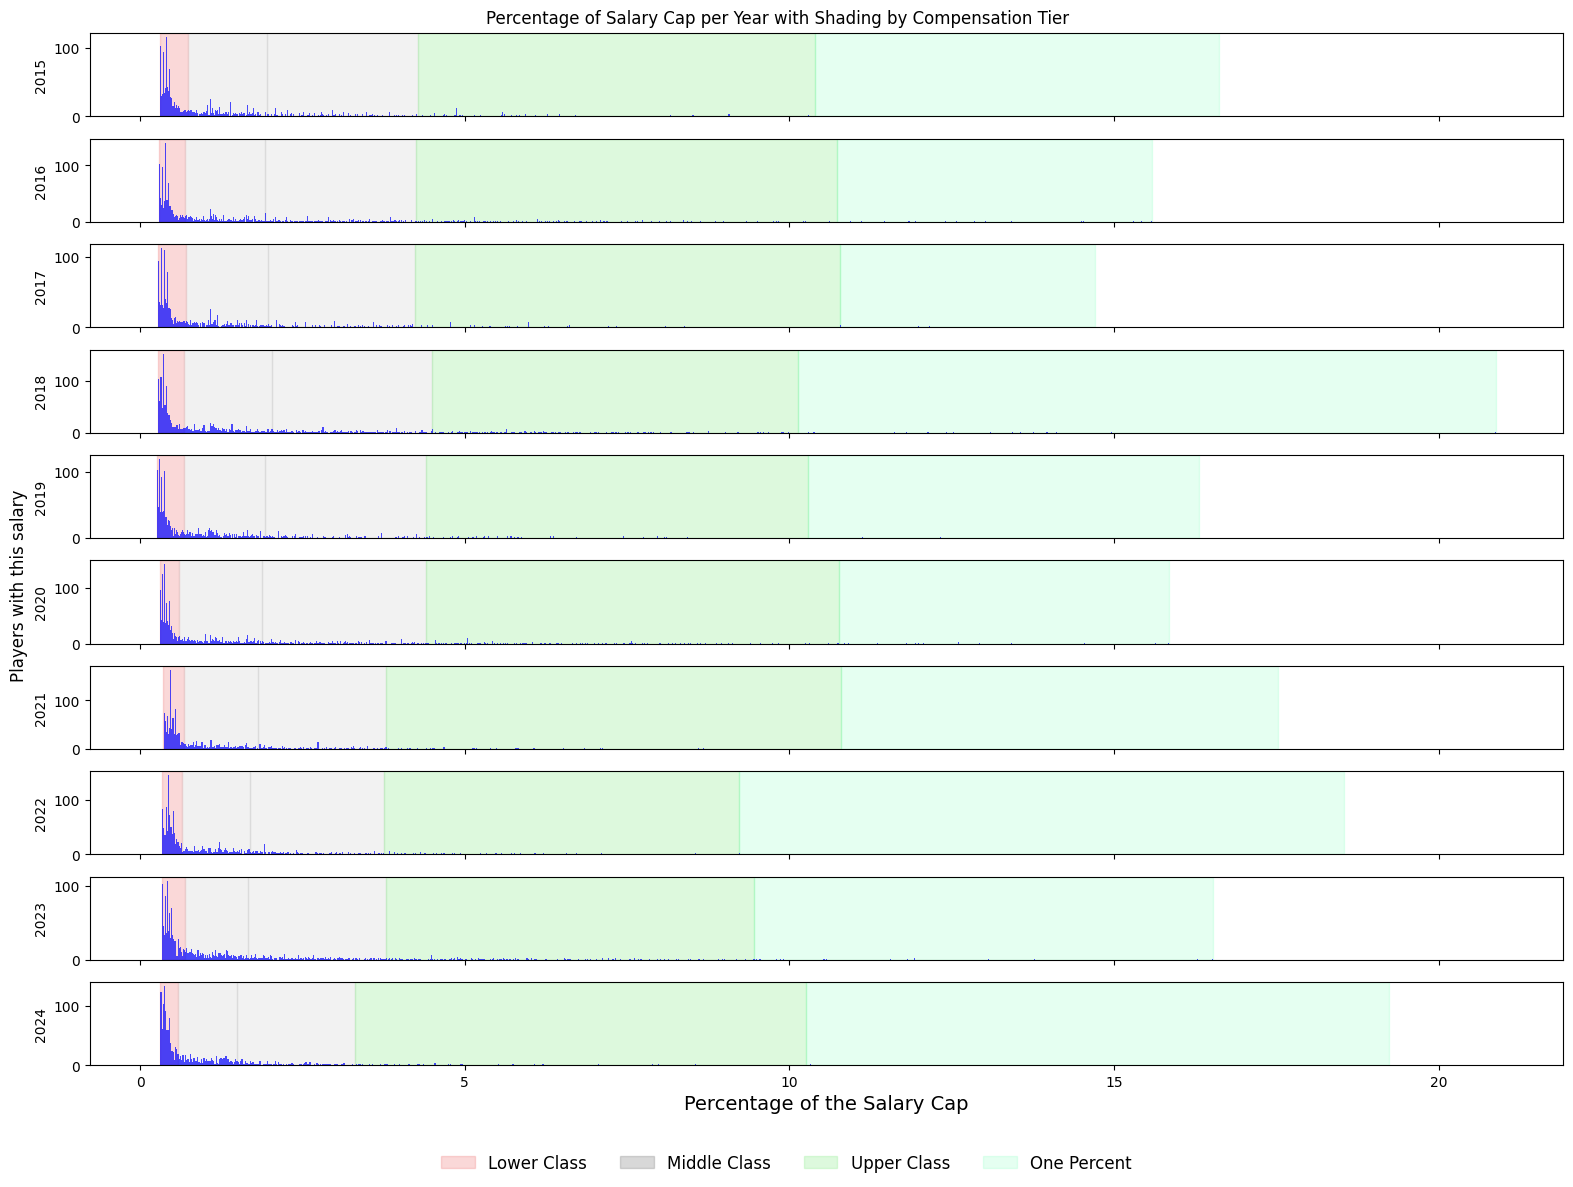

In [9]:
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(16, 12), sharex = True)

for i, category in enumerate(years):
    ax = axes[i]
    subset = all_data[all_data['year'] == category]
    #SHADE 
    min_sal = bounds_per['min_sal'][category]
    lower = bounds_per['lower'][category]
    upper = bounds_per['upper'][category]
    high = bounds_per['high'][category]
    onep = bounds_per['onep'][category]
    max_sal = bounds_per['max_sal'][category]
    
    ax.axvspan(min_sal, lower, color='lightcoral', alpha=0.3)
    ax.axvspan(lower, upper, color='lightgray', alpha=0.3)
    ax.axvspan(upper, high, color='gray', alpha=0.1)
    ax.axvspan(high, onep, color='lightgreen', alpha=0.3)
    ax.axvspan(onep, max_sal, color='springgreen', alpha=0.1)

    ax.hist(subset['percent'], bins=1000, color='blue', alpha=0.7)
    ax.set_ylabel(category)
ax.set_xlabel('Percentage of the Salary Cap', fontsize=14)
fig.supylabel('Players with this salary')
fig.suptitle('Percentage of Salary Cap per Year with Shading by Compensation Tier')

plt.tight_layout()
legend_patches = [
    mpatches.Patch(color='lightcoral',alpha=0.3, label='Lower Class'),
    mpatches.Patch(color='gray', alpha=0.3, label='Middle Class'),
    mpatches.Patch(color='lightgreen',alpha=0.3, label='Upper Class'),
    mpatches.Patch(color='springgreen', alpha=0.1, label='One Percent'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, fontsize=12, frameon=False)


plt.subplots_adjust(bottom = .1, left = .07)
plt.show()

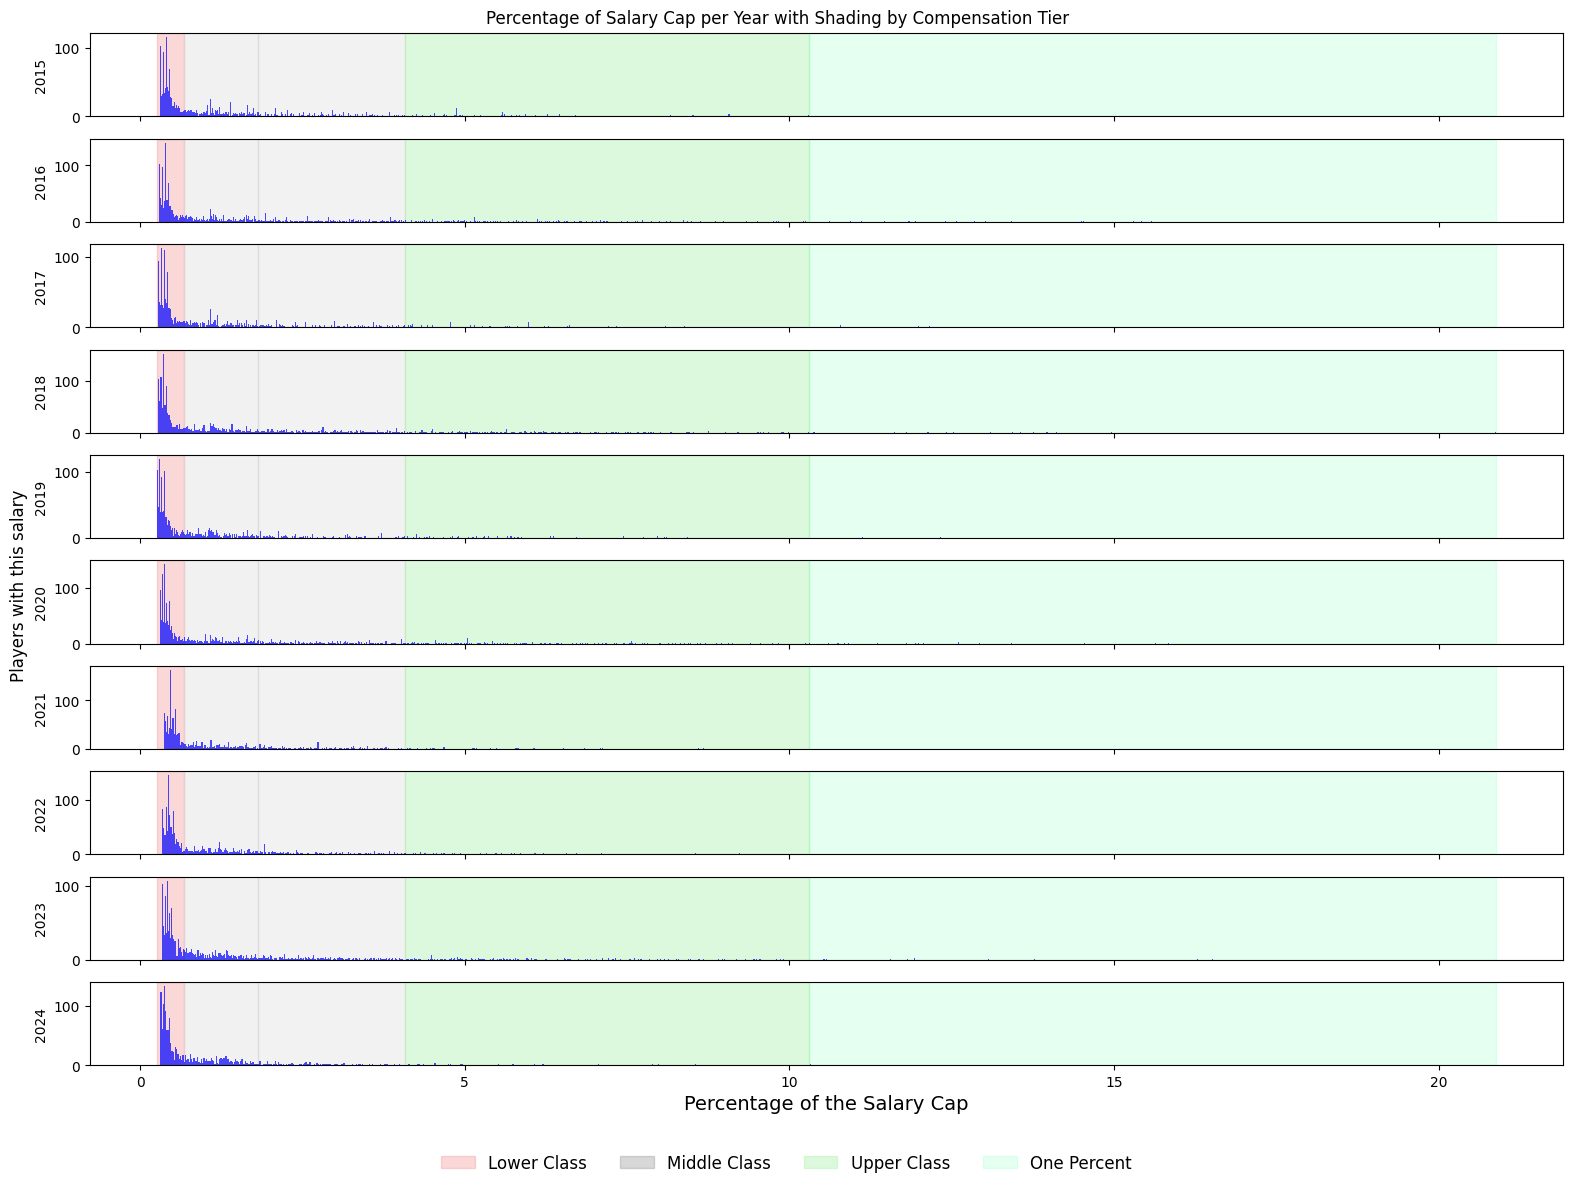

In [10]:
min_sal = all_data['percent'].quantile(0).round(2)
lower = all_data['percent'].quantile(0.50).round(2)
upper = all_data['percent'].quantile(0.75).round(2)
high = all_data['percent'].quantile(0.90).round(2)
onep = all_data['percent'].quantile(0.99).round(2)
max_sal = all_data['percent'].quantile(1).round(2)
bound = pd.Series({'min_sal': min_sal,'lower': lower, 'upper': upper, 'high':high, 'onep':onep, 'max_sal':max_sal})
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(16, 12), sharex = True)

for i, category in enumerate(years):
    ax = axes[i]
    subset = all_data[all_data['year'] == category]
    #SHADE     
    ax.axvspan(min_sal, lower, color='lightcoral', alpha=0.3)
    ax.axvspan(lower, upper, color='lightgray', alpha=0.3)
    ax.axvspan(upper, high, color='gray', alpha=0.1)
    ax.axvspan(high, onep, color='lightgreen', alpha=0.3)
    ax.axvspan(onep, max_sal, color='springgreen', alpha=0.1)

    ax.hist(subset['percent'], bins=1000, color='blue', alpha=0.7)
    ax.set_ylabel(category)

ax.set_xlabel('Percentage of the Salary Cap', fontsize=14)
fig.supylabel('Players with this salary')
fig.suptitle('Percentage of Salary Cap per Year with Shading by Compensation Tier')

plt.tight_layout()
legend_patches = [
    mpatches.Patch(color='lightcoral',alpha=0.3, label='Lower Class'),
    mpatches.Patch(color='gray', alpha=0.3, label='Middle Class'),
    mpatches.Patch(color='lightgreen',alpha=0.3, label='Upper Class'),
    mpatches.Patch(color='springgreen', alpha=0.1, label='One Percent'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, fontsize=12, frameon=False)


plt.subplots_adjust(bottom = .1, left = .07)
plt.show()

Below are the breakdown of the bounds above, as percentages of the salary cap and as dollars using the mean of the salary cap over the last 10 years.

In [24]:
bound

min_sal     0.26
lower       0.67
upper       1.81
high        4.08
onep       10.30
max_sal    20.88
dtype: float64

In [12]:
bound* statistics.mean(cap)/100

min_sal      494013.0
lower       1273033.5
upper       3439090.5
high        7752204.0
onep       19570515.0
max_sal    39673044.0
dtype: float64

Below is the amount of players per class using the standard definiton.

In [13]:
def is_middle_quin(x):
    if x < bound['lower']:
        return 'lower'
    if x < bound['upper']:
        return 'middle'
    if x < bound['high']:
        return 'upper middle'
    if x < bound['onep']:
        return 'upper'
    return 'one percent'

all_data['class'] = all_data['percent'].apply(is_middle_quin)
breakdown = all_data.pivot_table(index='year', columns='class', aggfunc='size', fill_value=0)
breakdown['total middle'] = 0
breakdown['players'] = 0
for i in years:
    breakdown['total middle'][i] = breakdown['middle'][i]+breakdown['upper middle'][i]
    breakdown['players'][i] = breakdown['lower'][i] +breakdown['total middle'][i] +breakdown['upper'][i] +breakdown['one percent'][i]
breakdown = breakdown[['lower','middle','upper middle','total middle','upper','one percent','players']]
breakdown

class,lower,middle,upper middle,total middle,upper,one percent,players
year,,,,,,,
2015,788,420,268,688,156,18,1650
2016,825,406,263,669,158,18,1670
2017,819,402,262,664,163,19,1665
2018,826,381,262,643,170,17,1656
2019,827,400,247,647,172,17,1663
2020,884,370,248,618,167,22,1691
2021,852,425,271,696,137,18,1703
2022,845,448,244,692,133,12,1682
2023,822,458,235,693,139,11,1665


Below is the percentage of the players that are in each class.

In [14]:
classes = ['lower','middle','upper middle','total middle','upper','one percent']
counts = all_data.groupby('year').count()

for i in classes:
    for j in years:
        breakdown[i][j] = (float(breakdown[i][j])/float(counts['Cap Number'][j]))*100
breakdown.round(2)

class,lower,middle,upper middle,total middle,upper,one percent,players
year,,,,,,,
2015,47.76,25.45,16.24,41.70,9.45,1.09,1650
2016,49.40,24.31,15.75,40.06,9.46,1.08,1670
2017,49.19,24.14,15.74,39.88,9.79,1.14,1665
2018,49.88,23.01,15.82,38.83,10.27,1.03,1656
2019,49.73,24.05,14.85,38.91,10.34,1.02,1663
2020,52.28,21.88,14.67,36.55,9.88,1.30,1691
2021,50.03,24.96,15.91,40.87,8.04,1.06,1703
2022,50.24,26.63,14.51,41.14,7.91,0.71,1682
2023,49.37,27.51,14.11,41.62,8.35,0.66,1665


Below is the change of the size in the middle class over time.

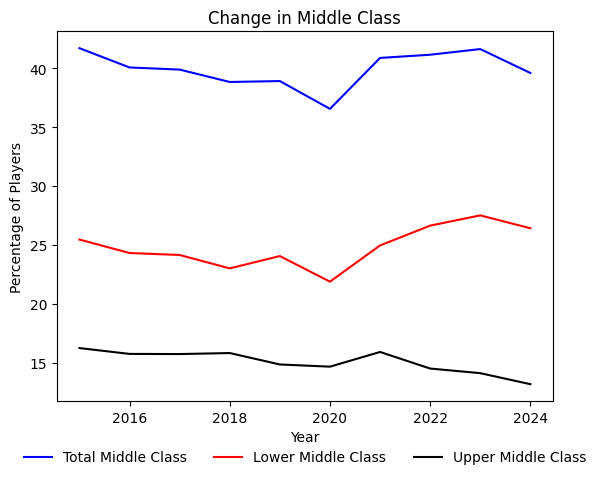

In [15]:
plt.plot(breakdown['total middle'], label = 'Total Middle Class', color = 'blue')
plt.plot(breakdown['middle'], label = 'Lower Middle Class', color = 'red')
plt.plot(breakdown['upper middle'], label = 'Upper Middle Class', color = 'black')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)
plt.title('Change in Middle Class')
plt.xlabel('Year')
plt.ylabel('Percentage of Players')
plt.show()

Below is the change of the size in classes, first year over year, then the change since 2015.

In [16]:
classes = ['lower','middle','upper middle','total middle','upper','one percent','players']
diff_by_year = breakdown.copy()
for i in classes:
    for j in range(9):
        #diff_by_year[i][2024-j] = breakdown[i][2016+j]-breakdown[i][2015+j] # absolute change
        diff_by_year[i][2024-j] = ((breakdown[i][2016+j]-breakdown[i][2015+j])/breakdown[i][2015+j])*100 # relative change
        diff_by_year[i][2024-j] = diff_by_year[i][2024-j].round(3)
    diff_by_year[i][2015] = 0
diff_by_year

class,lower,middle,upper middle,total middle,upper,one percent,players
year,,,,,,,
2015,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2016,7.349,-3.975,-6.627,-4.875,-23.441,54.103,6.186
2017,-1.729,3.276,-2.705,1.167,5.578,-7.397,-1.011
2018,0.417,6.728,-8.839,0.667,-1.708,-32.501,-1.233
2019,-4.299,14.055,8.504,11.828,-18.542,-18.758,0.710
2020,5.122,-9.032,-1.258,-6.064,-4.515,27.269,1.684
2021,-0.300,4.545,-6.122,0.199,0.751,-0.421,0.423
2022,1.403,-4.709,0.543,-2.636,4.861,-10.040,-0.541
2023,-0.429,-0.688,-0.081,-0.449,3.474,5.873,-0.299


In [17]:
diff_from_15 = breakdown.copy()
for i in classes:
    for j in range(9):
        diff_from_15[i][2024-j] = ((breakdown[i][2024-j]-breakdown[i][2015])/breakdown[i][2015])*100
        diff_from_15[i][2024-j] = diff_from_15[i][2024-j].round(3)
    diff_from_15[i][2015] = 0
diff_from_15

class,lower,middle,upper middle,total middle,upper,one percent,players
year,,,,,,,
2015,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2016,3.442,-4.491,-3.041,-3.926,0.069,-1.198,1.212
2017,2.998,-5.148,-3.120,-4.358,3.546,4.605,0.909
2018,4.443,-9.614,-2.593,-6.879,8.580,-5.898,0.364
2019,4.129,-5.506,-8.556,-6.694,9.395,-6.294,0.788
2020,9.463,-14.041,-9.706,-12.352,4.456,19.259,2.485
2021,4.757,-1.959,-2.028,-1.986,-14.913,-3.112,3.212
2022,5.193,4.637,-10.687,-1.332,-16.366,-34.602,1.939
2023,3.375,8.065,-13.103,-0.181,-11.700,-39.439,0.909


Below is the percentage of the salary number that goes to the middle class for each year for each team. We then found the 75% quantile to set the goal size of the middle class.

In [18]:
def is_middle_full(x):
    if x == 'upper middle' or x == 'middle':
        return True
    else:
        return False
all_data['middle'] = all_data['class'].apply(is_middle_full)
percent_of_cap_middle = all_data[all_data['middle']==True].groupby(['Team','year']).sum('percent').round(1)
percent_of_cap_middle['percent'].unstack()

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Team,,,,,,,,,,
49ers,30.4,30.8,45.3,40.6,48.3,48.9,41.4,42.0,40.0,32.8
Bears,26.3,35.6,46.6,53.7,37.1,33.9,38.0,24.2,38.5,36.7
Bengals,41.5,43.5,39.1,30.4,38.7,46.8,41.2,44.3,31.5,37.0
Bills,42.4,41.2,20.8,38.2,51.0,49.7,42.2,41.7,47.5,31.6
Broncos,26.0,33.1,26.9,32.5,29.8,35.5,41.3,33.5,31.9,40.4
Browns,40.9,26.7,25.6,45.4,38.0,32.8,33.6,37.7,31.3,30.3
Buccaneers,36.9,37.2,48.3,38.1,28.5,30.7,38.9,40.7,26.3,30.0
Cardinals,33.6,35.1,30.5,32.3,28.1,37.4,43.1,29.7,18.3,37.9
Chargers,40.8,40.4,39.1,41.1,27.3,42.3,33.5,35.9,26.9,27.0


In [19]:
percs = percent_of_cap_middle.reset_index()
percs['percent'].quantile(.75)

42.4